Feature Engineering:
Extract useful insights from factors:


In [9]:
import pandas as pd
import numpy as np
df = pd.read_csv("data copy.csv")
df.describe()
df['6_hour_lag_coinbase'] = df['coinbase_premium_index'].shift(6)
df['24_hour_lag_coinbase'] = df['coinbase_premium_index'].shift(24)
df['taker_buy_sell_ratio_sma_6'] = df['taker_buy_sell_ratio'].rolling(window=6).mean()
df['taker_buy_sell_ratio_sma_24'] = df['taker_buy_sell_ratio'].rolling(window=24).mean()
df['price_std_6hr'] = df['close'].rolling(window=6).std()
df['price_std_24'] = df['close'].rolling(window=24).std()
df = df.iloc[24:]  # Drop first 30 rows to get rid of NaN values
df.head(50)
df.to_csv("data.csv", index=False)


# Data PreProcessing

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def prepare_trading_data(df, split_date='2024-03-25 00:00:00', 
                        n_future_bars=72,
                        tp_threshold=0.045,
                        sl_threshold=-0.05,
                        volatility_threshold=2.3):
    """
    Enhanced trading data preparation with:
    - Proper time-series split
    - Volatility-aware signal generation
    - Leakage-proof scaling
    - HMM-ready outputs
    
    Returns:
    - X_train_scaled, X_test_scaled: Scaled feature DataFrames
    - y_train, y_test: Target signals
    - train_regime, test_regime: Raw features for HMM
    - scaler: Fitted scaler object
    """
    
    # Create copy and ensure datetime index
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index('datetime')
    
    # Calculate targets ------------------------------------------------------
    df['future_return'] = df['close'].pct_change(n_future_bars).shift(-n_future_bars)
    rolling_vol = df['price_std_6hr']
    
    # Volatility filter
    vol_filter = rolling_vol > (rolling_vol.mean() * volatility_threshold)
    
    # 3-Class signal logic
    conditions = [
        (df['future_return'] > tp_threshold) & (~vol_filter),   # Long
        (df['future_return'] < sl_threshold) & (~vol_filter),   # Short
        (vol_filter)      # Neutral
    ]
    
    df['3class_signal'] = np.select(
    condlist=conditions,  
    choicelist=[1, -1, 0],  
    default=0
    )
    
    # Time-based split -----------------------------------------------------
    train = df.loc[:split_date]
    test = df.loc[split_date:]
    
    # Define features (exclude targets and metadata)
    feature_cols = [col for col in df.columns if col not in [
        'future_return', '3class_signal', 'start_time', 'close', 'datetime'
    ]]
    
    # Split features and targets
    X_train, X_test = train[feature_cols], test[feature_cols]
    y_train, y_test = train['3class_signal'], test['3class_signal']
    
    # Data scaling ----------------------------------------------------------
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    # Prepare HMM data (unscaled) ------------------------------------------
    train_regime = X_train.copy()
    test_regime = X_test.copy()
    
    # Clean NaN values
    valid_idx = X_train_scaled.index.intersection(y_train.dropna().index)
    X_train_scaled = X_train_scaled.loc[valid_idx]
    y_train = y_train.loc[valid_idx]
    
    return X_train_scaled, X_test_scaled, y_train, y_test, train_regime, test_regime, scaler

df = pd.read_csv('data.csv')
X_train, X_test, y_train, y_test, train_regime, test_regime, scaler = prepare_trading_data(df)

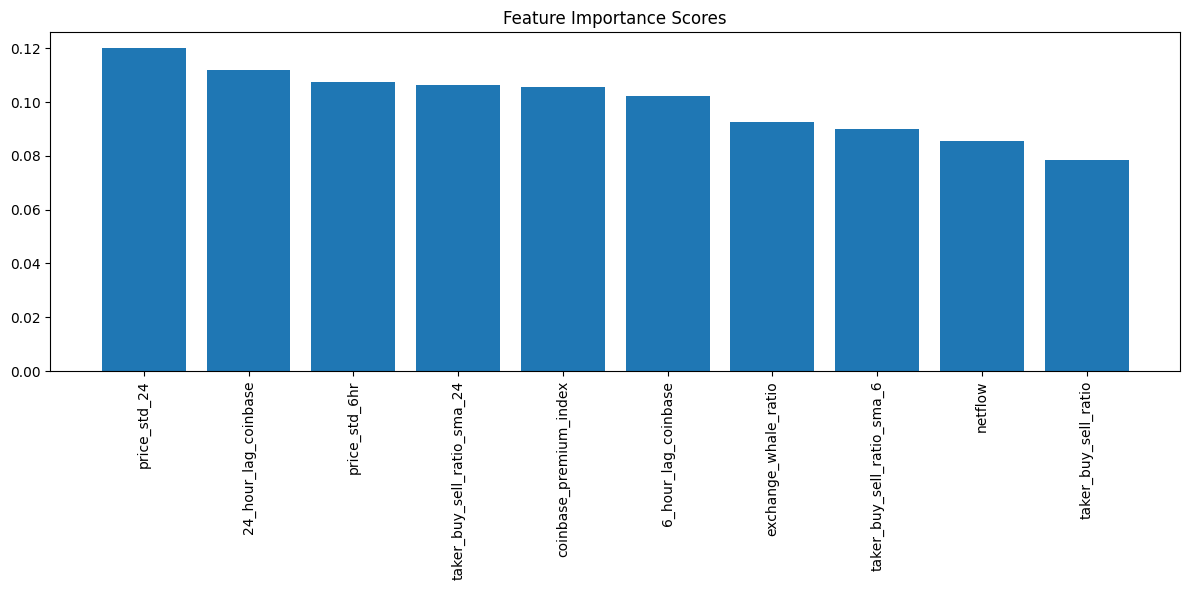

price_std_24: 0.1199
24_hour_lag_coinbase: 0.1119
price_std_6hr: 0.1076
taker_buy_sell_ratio_sma_24: 0.1062
coinbase_premium_index: 0.1056
6_hour_lag_coinbase: 0.1021
exchange_whale_ratio: 0.0927
taker_buy_sell_ratio_sma_6: 0.0899
netflow: 0.0857
taker_buy_sell_ratio: 0.0783


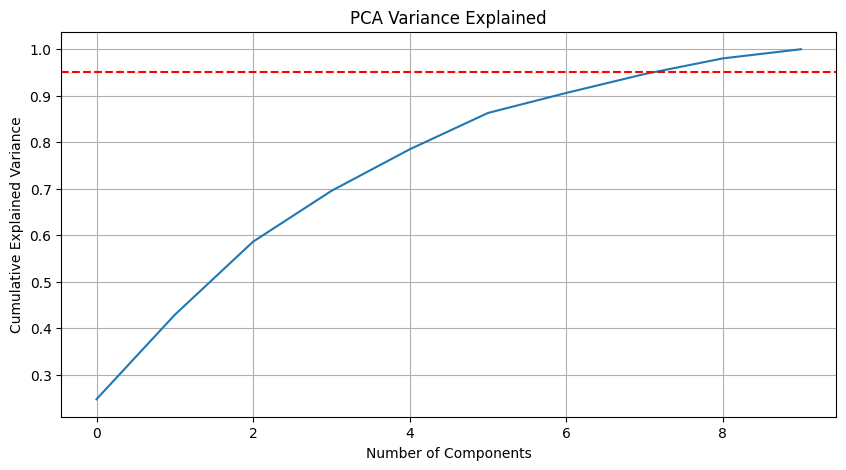

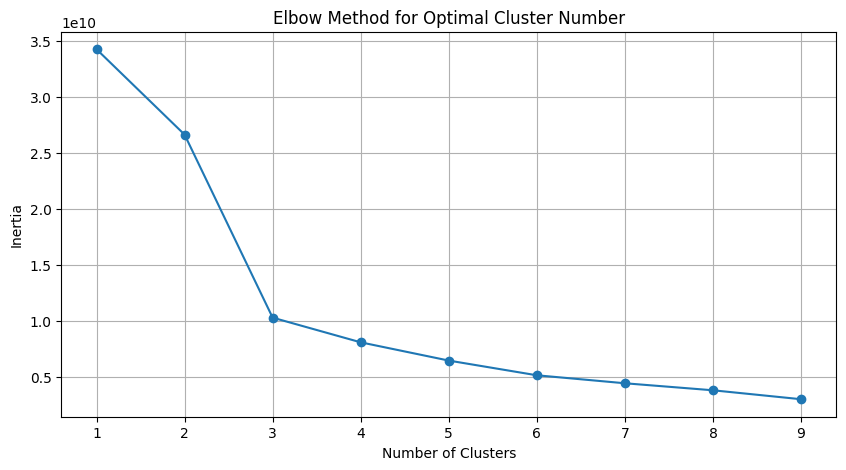

In [11]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Feature Importance Analysis (Supervised)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), importances[sorted_idx], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=90)
plt.title("Feature Importance Scores")
plt.tight_layout()
plt.show()
for i in range(10):
    print(f"{X_train.columns[sorted_idx[i]]}: {importances[sorted_idx[i]]:.4f}")

# 2. Elbow Method for Dimensionality (Unsupervised)
# First reduce dimensionality with PCA
pca = PCA().fit(X_train)

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title("PCA Variance Explained")
plt.grid()
plt.show()

# 3. Elbow Curve for KMeans Clustering (Regime Detection)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_regime)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title("Elbow Method for Optimal Cluster Number")
plt.grid()
plt.show()

At 7 components: The curve is very close to 0.95 (95% cumulative explained variance), as indicated by the red dashed line. This means that by using the top 7 principal components, it can retain approximately 95% of the total variance present in the original dataset.
Diminishing Returns: Notice that after around 7 components, the curve starts to flatten out.

This indicates that adding more components beyond this point contributes relatively less to explaining the overall variance in the data.   


Why Taking the Top 7 Features Might Be a Good Idea:

High Variance Retention: Retaining 95% of the variance is often considered a good balance between reducing the dimensionality of the data and preserving most of the important information.    

Dimensionality Reduction: If the original dataset had significantly more than 7 features, reducing it to 7 principal components can lead to a simpler and more computationally efficient model. This can help with training speed, model interpretability, and potentially prevent overfitting.   

Capturing Key Information: The principal components that explain the most variance are the ones that capture the most significant underlying patterns and relationships in the data. By focusing on these, it can help training the model on the most informative aspects of all features.

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19513 entries, 2022-01-02 00:00:00 to 2024-03-25 00:00:00
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   exchange_whale_ratio         19513 non-null  float64
 1   coinbase_premium_index       19513 non-null  float64
 2   taker_buy_sell_ratio         19513 non-null  float64
 3   netflow                      19513 non-null  float64
 4   6_hour_lag_coinbase          19513 non-null  float64
 5   24_hour_lag_coinbase         19513 non-null  float64
 6   taker_buy_sell_ratio_sma_6   19513 non-null  float64
 7   taker_buy_sell_ratio_sma_24  19513 non-null  float64
 8   price_std_6hr                19513 non-null  float64
 9   price_std_24                 19513 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB


In [13]:
# Drop unnecessary columns
X_train.drop(columns=['taker_buy_sell_ratio_sma_6','netflow','taker_buy_sell_ratio'], inplace=True)

# Run Model

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from collections import deque

class SelfLearningTradingModel:
    def __init__(self, n_regimes=3, cnn_lookback=60, feature_cols=None):
        # HMM for regime detection
        self.hmm = hmm.GaussianHMM(n_components=n_regimes, 
                                covariance_type="diag", 
                                n_iter=1000)
        
        # CNN feature extractor (input shape will be set during first training)
        self.cnn = None  
        self.scaler = None  # Will reuse existing scaler
        self.feature_cols = feature_cols or [
            'exchange_whale_ratio', 
            'coinbase_premium_index',
            'taker_buy_sell_ratio_sma_6',
            'taker_buy_sell_ratio_sma_24',
            'price_std_24', 
            'netflow', 
            'taker_buy_sell_ratio'
        ]
        print("feature_cols: ", self.feature_cols)
        self.lookback = cnn_lookback
        self.current_regime = None

    def _build_cnn(self, input_shape):
        """Build CNN only when input shape is known"""
        model = tf.keras.Sequential([
            tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Conv1D(128, 3, activation='relu'),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
        return model

    def train(self, X_train_scaled, y_train, train_regime, existing_scaler):
        # 1. Store pre-fitted scaler
        self.scaler = existing_scaler
        
        # 2. Train HMM on unscaled regime data
        self.hmm.fit(train_regime[self.feature_cols])
        self.current_regime = self.hmm.predict(train_regime[self.feature_cols].iloc[-1:])[0]
        
        # 3. Prepare 3D sequences (using already scaled data)
        X_3d = self._prepare_3d_features(X_train_scaled[self.feature_cols])
        y_3d = y_train.iloc[self.lookback-1:]  # Align labels
        
        # 4. Initialize and train CNN
        if self.cnn is None:
            self.cnn = self._build_cnn(input_shape=(self.lookback, len(self.feature_cols)))
        
        self.cnn.fit(X_3d, y_3d + 1, epochs=10, batch_size=32)  # y+1 to map [-1,0,1]→[0,1,2]

    def _prepare_3d_features(self, data):
        """Convert to CNN-friendly 3D format without re-scaling"""
        sequences = []
        for i in range(len(data) - self.lookback + 1):
            seq = data.iloc[i:i+self.lookback]
            sequences.append(seq)
        return np.array(sequences)

    def predict(self, recent_data):
        """Predict using already scaled data"""
        # 1. Detect regime (using original unscaled data)
        current_regime = self.hmm.predict(recent_data[self.feature_cols].iloc[-self.lookback:])[-1]
        
        # 2. Prepare CNN input (using pre-scaled values)
        seq = self._prepare_3d_features(recent_data[self.feature_cols])[-1:]
        
        # 3. Generate prediction
        proba = self.cnn.predict(seq)[0]
        return np.argmax(proba) - 1  # Convert back to [-1,0,1]

# Usage with existing scaled data
model = SelfLearningTradingModel(
    n_regimes=3,
    cnn_lookback=32,
    feature_cols=X_train.columns.tolist()  # Pass actual feature names
)
# Train using pre-scaled data
model.train(X_train, y_train, train_regime, scaler)
# 1. Generate predictions for the entire test set
X_test_3d = model._prepare_3d_features(X_test[model.feature_cols])
y_pred = np.argmax(model.cnn.predict(X_test_3d), axis=1) - 1  # Convert back to [-1,0,1]

# 2. Align dates accounting for lookback window
test_dates = X_test.index[model.lookback-1:]

df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df[df['datetime'] >= '2024-03-25']
df = df.set_index('datetime')

# 3. Create a temporary DataFrame to ensure alignment
temp_df = pd.DataFrame({
    'actual_signal': y_test,
    'close_price': df['close']
}, index=X_test.index)

# 4. Slice the data to match our lookback window
results_df = temp_df.iloc[model.lookback-1:].copy()
results_df['datetime'] = results_df.index
results_df['predicted_signal'] = y_pred
results_df['trade_count'] = 0
results_df['cumu_pnl'] = 0.0
results_df['drawdown'] = 0.0
results_df.loc['daily_pnl'] = 0.0

# 5. Add human-readable signal labels
signal_map = {-1: 'Short', 0: 'Neutral', 1: 'Long'}
results_df['actual_position'] = results_df['actual_signal'].map(signal_map)
results_df['predicted_position'] = results_df['predicted_signal'].map(signal_map)

# Ensure test_regime is properly indexed
if not test_regime.index.equals(X_test.index):
    test_regime = test_regime.set_index(X_test.index)

# Predict regimes and align lengths
regime_predictions = model.hmm.predict(
    test_regime[model.feature_cols].iloc[model.lookback-1:]
)

# Ensure the length matches results_df
results_df = results_df.iloc[:len(regime_predictions)].copy()
results_df['regime'] = regime_predictions

results_df['original_index'] = results_df.index
results_df = results_df.reset_index(drop=True)

# 7. Calculate daily returns
for i in range(1, len(results_df)):
    results_df.loc[i, 'trade_count'] = abs(results_df['predicted_signal'].iloc[i] - results_df['predicted_signal'].iloc[i-1])
for i in range (1, len(results_df)):
    results_df.loc[i, 'daily_pnl'] = results_df.loc[i-1, 'predicted_signal'] * ((results_df['close_price'].iloc[i] / results_df['close_price'].iloc[i-1]) - 1) - results_df.loc[i, 'trade_count'] * 0.0006
    results_df.loc[i, 'cumu_pnl'] = results_df.loc[i-1, 'cumu_pnl'] + results_df.loc[i, 'daily_pnl']
    results_df.loc[i, 'drawdown'] = results_df.loc[i, 'cumu_pnl'] - results_df.loc[:i, 'cumu_pnl'].max()

#convert index back to original_index
results_df = results_df.set_index('original_index')

mdd = results_df['drawdown'].min()
trade_counts = results_df['trade_count'].sum()
Annual_return = results_df['daily_pnl'].mean()* 365 * 24 
if results_df['daily_pnl'].std() != 0:
    sharpe_ratio = results_df['daily_pnl'].mean() * np.sqrt(365 * 24 ) / results_df['daily_pnl'].std()
else:
    sharpe_ratio = 0
if mdd != 0:
    Calmar_ratio = abs(results_df['daily_pnl'].mean() * np.sqrt(365 * 24 )) / abs(mdd)
else:
    Calmar_ratio = 0
results = [sharpe_ratio, mdd, trade_counts, Calmar_ratio, Annual_return]
print("sharpe_ratio: ", sharpe_ratio)
print("mdd: ", mdd)
print("trade_counts: ", trade_counts)
print("Annual_return: ", Annual_return)
print("Calmar_ratio: ", Calmar_ratio)
# 8. Export to CSV (two versions)
# Version 1: Raw numerical data
results_df.to_csv('test_predictions_raw.csv', index=False, columns=[
    'datetime', 'actual_signal', 'predicted_signal', 'regime', 'close_price'
])

# Version 2: Formatted trading log
results_df.to_csv('trading_log_formatted.csv', index=False, columns=[
    'datetime', 'actual_position', 'predicted_position', 'regime', 
    'close_price', 'daily_pnl', 'cumu_pnl'
])

# 9. Export probabilities for each class
proba_matrix = model.cnn.predict(X_test_3d)
proba_df = pd.DataFrame(proba_matrix, 
                    columns=['prob_short', 'prob_neutral', 'prob_long'],
                    index=test_dates)
proba_df.to_csv('signal_probabilities.csv')

print(f"Exported {len(results_df)} test predictions to CSV files:")
print("test_predictions_raw.csv")
print("trading_log_formatted.csv")
print("signal_probabilities.csv")

feature_cols:  ['exchange_whale_ratio', 'coinbase_premium_index', '6_hour_lag_coinbase', '24_hour_lag_coinbase', 'taker_buy_sell_ratio_sma_24', 'price_std_6hr', 'price_std_24']
Epoch 1/10


c:\Users\ch\anaconda3\envs\test\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7164
Epoch 2/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6651
Epoch 3/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6055
Epoch 4/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5589
Epoch 5/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4836
Epoch 6/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4292
Epoch 7/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3754
Epoch 8/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3440
Epoch 9/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3062
Epoch 10/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2828
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


C:\Users\ch\AppData\Local\Temp\ipykernel_1076\191111959.py:136: FutureWarning: Setting an Index with object dtype into a DataFrame will stop inferring another dtype in a future version. Cast the Index explicitly before setting it into the DataFrame.
  results_df['original_index'] = results_df.index


sharpe_ratio:  2.2092339906430416
mdd:  -0.3446626917888884
trade_counts:  416.0
Annual_return:  0.672336774451476
Calmar_ratio:  0.020842055003904476
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
Exported 8724 test predictions to CSV files:
test_predictions_raw.csv
trading_log_formatted.csv
signal_probabilities.csv


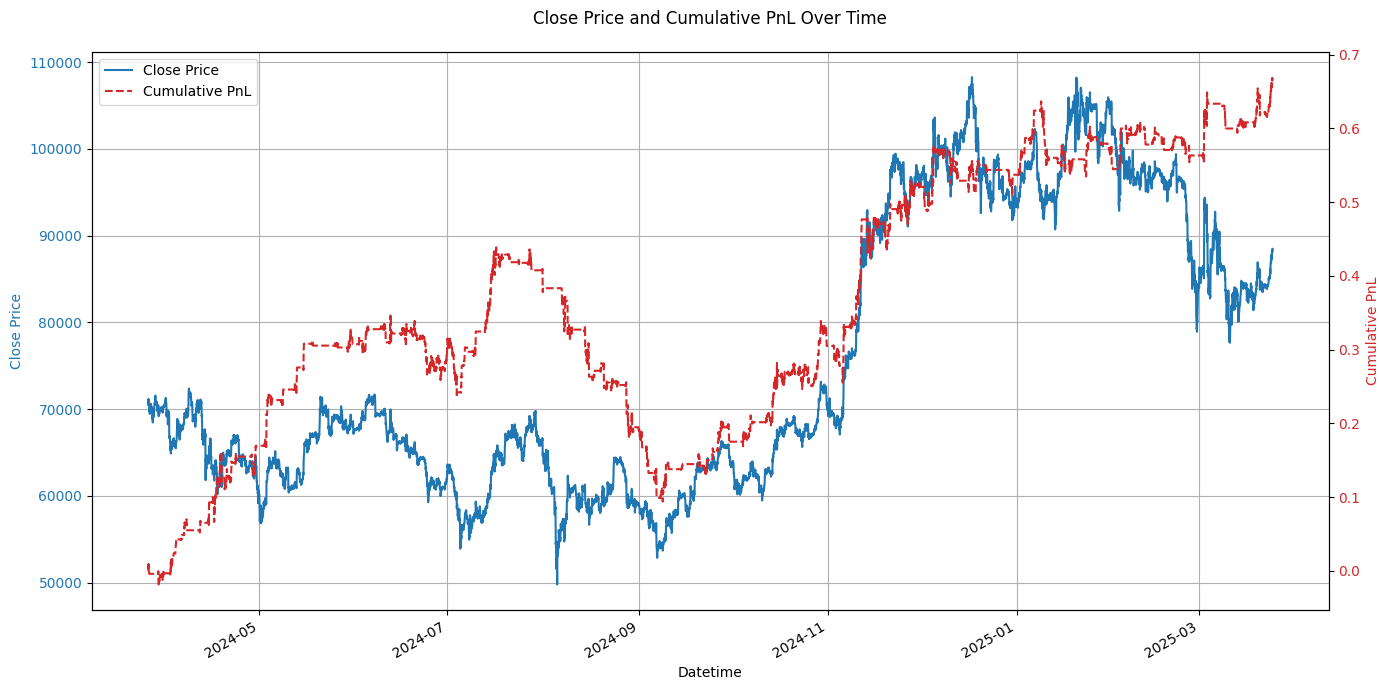

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load  CSV data
df = pd.read_csv('trading_log_formatted.csv', parse_dates=['datetime'])

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close_price on primary axis (left)
color = 'tab:blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(df['datetime'], df['close_price'], color=color, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary axis (right)
ax2 = ax1.twinx()

# Plot cumu_pnl on secondary axis
color = 'tab:red'
ax2.set_ylabel('Cumulative PnL', color=color)
ax2.plot(df['datetime'], df['cumu_pnl'], color=color, linestyle='--', label='Cumulative PnL')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and grid
plt.title('Close Price and Cumulative PnL Over Time', pad=20)
ax1.grid(True)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Format x-axis to show dates nicely
fig.autofmt_xdate()

# Adjust layout and show plot
plt.tight_layout()
plt.show()